# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Initialize simulator

In [3]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 7
ROUNDS = 7
OTHER_DATE = '2021-11-11'
_RESETS = False
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


# Initialize stim circuit

In [4]:
# AFTER_CLIFFORD_DEPOLARIZATION = 0.8e-3
# AFTER_RESET_FLIP_PROBABILITY = 0.1e-2
# BEFORE_MEASURE_FLIP_PROBABILITY = 0.5e-2 
# BEFORE_ROUND_DATA_DEPOLARIZATION = 0.8e-2

# Good error rate _resets = True
AFTER_CLIFFORD_DEPOLARIZATION = 3e-2
AFTER_RESET_FLIP_PROBABILITY = 0.8e-2
BEFORE_MEASURE_FLIP_PROBABILITY = 1e-2 
BEFORE_ROUND_DATA_DEPOLARIZATION = 3e-2

# AFTER_CLIFFORD_DEPOLARIZATION = 6e-2
# AFTER_RESET_FLIP_PROBABILITY = 1.6e-2
# BEFORE_MEASURE_FLIP_PROBABILITY = 2e-2 
# BEFORE_ROUND_DATA_DEPOLARIZATION = 6e-2


SHOTS = int(1e4)

In [5]:
import stim
stim_circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=AFTER_CLIFFORD_DEPOLARIZATION, #two-qubit-fidelity,
                                after_reset_flip_probability=AFTER_RESET_FLIP_PROBABILITY, #reset error,
                                before_measure_flip_probability=BEFORE_MEASURE_FLIP_PROBABILITY, #measurement error,
                                before_round_data_depolarization=BEFORE_ROUND_DATA_DEPOLARIZATION) #idle error)



meas_outcomes = stim_circuit.compile_sampler().sample(SHOTS)
counts = {}
for row in meas_outcomes:
    count_str = ''
    for nb, bit in enumerate(row):
        count_str += '0' if bit == False else '1'
        if (nb+1) % (DISTANCE-1) == 0 and nb < ROUNDS*(DISTANCE-1):
            count_str += ' ' 
    count_str = count_str[::-1]
    if count_str in counts:
        counts[count_str] += 1
    else:
        counts[count_str] = 1
print(counts)

{'0000101 000111 000111 000110 000110 100000 000000 000000': 1, '0000000 000000 100000 000000 000010 000000 000000 000000': 1, '0001101 010001 010011 001011 001011 001111 001111 000011': 1, '0010000 011000 011000 011000 011000 011000 011000 001000': 9, '0000000 000000 000000 000000 000000 000100 000110 000000': 1, '0010000 011010 011000 011000 000000 000000 000000 000000': 3, '0000010 000011 000011 000011 000011 000100 000000 000000': 1, '0000000 000000 000000 000000 000000 000000 000000 000000': 219, '0010100 011110 000000 000000 000000 000000 000000 000000': 1, '0100110 110101 110110 110100 110000 110000 111000 110000': 1, '0011000 010100 011000 011000 011000 011000 011000 011000': 1, '1101001 011101 001101 011101 100100 000000 001000 000000': 1, '0000001 000001 000001 000001 000001 000001 001000 000100': 1, '0101000 111100 111100 111100 110100 000000 000000 000000': 1, '0001000 001100 010100 010101 010100 001100 001100 000000': 1, '0100000 110000 110001 111000 010000 000000 000000 0

In [6]:
# not correct if we look at the count string!
verbose = False

no_reset_counts = {}
for count_key, shots in counts.items():
    parts=count_key.split(" ")
    print("parts:", parts) if verbose else None
    count_part = parts[0]
    print("count_part:", count_part) if verbose else None  
    check_parts = parts[1:]
    print("check_parts:", check_parts, "\n") if verbose else None

    for i in range(len(check_parts)):
        if i == 0:
            print("skipped last check part:", check_parts[-1], "\n") if verbose else None
            continue
        current_check_str = check_parts[-(i+1)]
        print("current_check_str:", current_check_str) if verbose else None
        prev_check_str = check_parts[-i]
        print("prev_check_str:", prev_check_str) if verbose else None
        new_check_str = ''
        for bit1, bit2 in zip(prev_check_str, current_check_str):
            new_check_str += str(int(bit1)^int(bit2))
        print("new_check_str:", new_check_str, "\n") if verbose else None
        check_parts[-(i+1)] = new_check_str

    print("\ncheck_parts after modulo:", check_parts) if verbose else None

    new_count_str = count_part + " " +  ' '.join(check_parts)
    print("\nnew_count_str:", new_count_str) if verbose else None

    
    if new_count_str in no_reset_counts:
        no_reset_counts[new_count_str] += shots
    else:
        no_reset_counts[new_count_str] = shots

if _RESETS is False:
    print("Taking no reset counts")
    counts = no_reset_counts
else: 
    print("Taking reset counts")

print(counts)

Taking no reset counts
{'0000101 100000 100111 100000 100110 100000 000000 000000': 1, '0000000 100010 100010 000010 000010 000000 000000 000000': 1, '0001101 000001 010000 000011 001000 000011 001100 000011': 1, '0010000 001000 010000 001000 010000 001000 010000 001000': 9, '0000000 000010 000010 000010 000010 000010 000110 000000': 1, '0010000 011010 000000 011000 000000 000000 000000 000000': 3, '0000010 000100 000111 000100 000111 000100 000000 000000': 1, '0000000 000000 000000 000000 000000 000000 000000 000000': 219, '0010100 011110 000000 000000 000000 000000 000000 000000': 1, '0100110 111111 001010 111100 001000 111000 001000 110000': 1, '0011000 010100 000000 011000 000000 011000 000000 011000': 1, '1101001 100001 111100 110001 101100 001000 001000 000000': 1, '0000001 001101 001100 001101 001100 001101 001100 000100': 1, '0101000 001000 110100 001000 110100 000000 000000 000000': 1, '0001000 011001 010101 000001 010100 000000 001100 000000': 1, '0100000 101001 011001 101000

In [7]:
IQ_data = simulator.counts_to_IQ(counts)

100%|██████████| 8826/8826 [00:00<00:00, 40665.66it/s]


# Get counts from IQ data

In [8]:
import cpp_soft_info

print(cpp_soft_info.get_counts(IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))

{'0000000 000000 000000 000000 000000 000000 000000 000000': 160, '0000000 000000 000000 000000 000000 000000 000000 000001': 1, '0000000 000000 000000 000000 000000 000000 000000 000010': 1, '0000000 000000 000000 000000 000000 000000 000000 011000': 1, '0000000 000000 000000 000000 000000 000000 000001 000001': 1, '0000000 000000 000000 000000 000000 000000 000010 000000': 3, '0000000 000000 000000 000000 000000 000000 000011 000000': 2, '0000000 000000 000000 000000 000000 000000 000100 000100': 1, '0000000 000000 000000 000000 000000 000000 000110 000000': 1, '0000000 000000 000000 000000 000000 000000 001000 000000': 1, '0000000 000000 000000 000000 000000 000000 001100 000100': 1, '0000000 000000 000000 000000 000000 000001 000000 000000': 4, '0000000 000000 000000 000000 000000 000001 000001 000000': 1, '0000000 000000 000000 000000 000000 000110 000000 000110': 1, '0000000 000000 000000 000000 000000 001000 000000 000000': 1, '0000000 000000 000000 000000 000000 001000 001000 0

# Decode IQ data

In [9]:
import pymatching
import stim

model = stim_circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

In [29]:
import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=True,
                                            p_offset = 1, p_multiplicator = 1)
print("num_errors:", result.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)

num_errors: 130 out of 10000 shots for _RESETS = False


In [11]:
matching = pymatching.Matching.from_detector_error_model(model)

p_meas = -1
# p_meas = 20e-2 


result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, IQ_data[:],
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=True)

print("num_errors:", result_informed.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
         
# takes 1s

num_errors: 163 out of 10000 shots for _RESETS = False


In [12]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=True)
print("num_errors:", result_flat.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)


num_errors: 203 out of 10000 shots for _RESETS = False


# Plot the results

In [13]:
print("\nIQ:", result.indices, "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)


IQ: [237, 256, 515, 590, 714, 1008, 1132, 1241, 1433, 1532, 1564, 1663, 1715, 1753, 1804, 1923, 2026, 2212, 2457, 2530, 2532, 2610, 2719, 2863, 2908, 3035, 3204, 3228, 3415, 3727, 3731, 3777, 3809, 3963, 3974, 4013, 4015, 4032, 4085, 4165, 4188, 4318, 4412, 4434, 4497, 4515, 4523, 4602, 4612, 4675, 4759, 4834, 4835, 4874, 4897, 5026, 5100, 5124, 5150, 5178, 5215, 5236, 5247, 5486, 5519, 5545, 5621, 5646, 5704, 5779, 5967, 6037, 6348, 6352, 6538, 6561, 6598, 6734, 6762, 6806, 7069, 7108, 7215, 7218, 7322, 7344, 7359, 7409, 7424, 7494, 7549, 7558, 7619, 7656, 7724, 7757, 7768, 7800, 7811, 7905, 8014, 8034, 8199, 8269, 8334, 8465, 8483, 8522, 8647, 8704, 8718, 8781, 8896, 8945, 8962, 9089, 9196, 9244, 9259, 9281, 9417, 9475, 9496, 9516, 9667, 9681, 9765, 9784, 9815, 9954] 
Flat: [237, 256, 465, 590, 714, 744, 866, 1013, 1199, 1336, 1428, 1433, 1532, 1581, 1610, 1663, 1675, 1682, 1691, 1804, 1839, 1869, 1923, 2026, 2176, 2182, 2199, 2212, 2245, 2342, 2352, 2457, 2530, 2610, 2719, 2770, 27

-----IQ True decoding -----


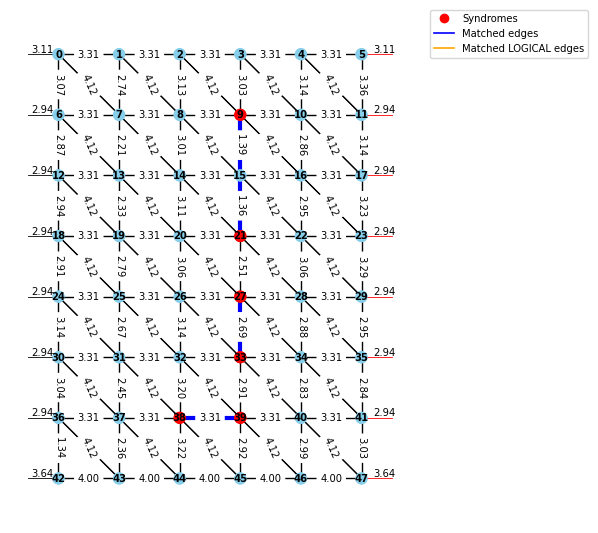

-----flat True decoding-----


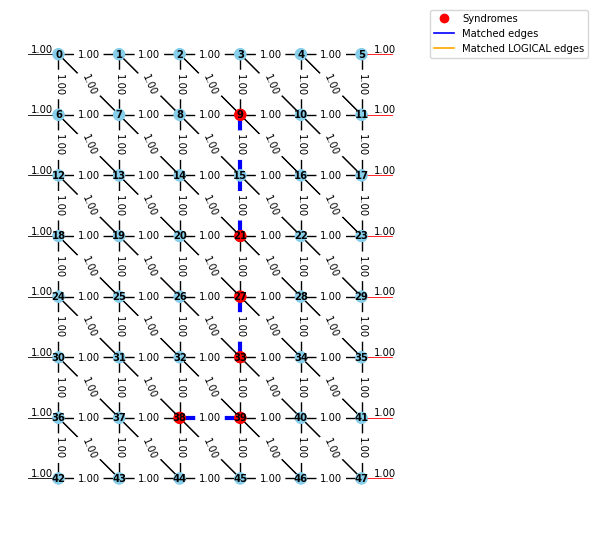

-----INFORMED True decoding-----


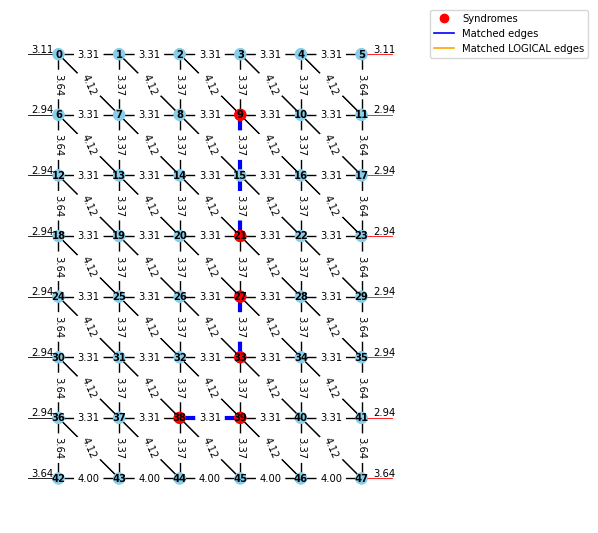

In [14]:
from soft_info import draw_matching_graph


index = 624

fig_size = (4, 13)
scale_factor = 0.6

to_be_result = result
details = to_be_result.error_details[index]
print(f"-----IQ {bool(not (index in to_be_result.indices))} decoding -----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print(f"-----flat {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_informed
details = to_be_result.error_details[index]
print(f"-----INFORMED {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [15]:
informed_not_in_iq = sorted(set(result_informed.indices) - set(result.indices))
print("indices that are in informed but not in IQ with len:", len(informed_not_in_iq))
print(informed_not_in_iq)
iq_not_in_informed = sorted(set(result.indices) - set(result_informed.indices))
print("indices that are in IQ but not in informed with len:", len(iq_not_in_informed))
print(iq_not_in_informed)

print()

iq_not_in_flat = sorted(set(result.indices) - set(result_flat.indices))
print("indices that are in IQ but not in flat with len:", len(iq_not_in_flat))
print(iq_not_in_flat)
flat_not_in_iq = sorted(set(result_flat.indices) - set(result.indices))
print("indices that are in flat but not in IQ with len:", len(flat_not_in_iq))
print(flat_not_in_iq)

indices that are in informed but not in IQ with len: 59
[433, 999, 1087, 1208, 1428, 1581, 2173, 2182, 2770, 2791, 2878, 3774, 3893, 3921, 4114, 4138, 4178, 4345, 4597, 4853, 4881, 5191, 5693, 6003, 6082, 6160, 6170, 6259, 6415, 6525, 6566, 6614, 6661, 6775, 6840, 6957, 7162, 7209, 7255, 7269, 7419, 7435, 7505, 7591, 7626, 7770, 7850, 7874, 7986, 8048, 8082, 8211, 8366, 8806, 9303, 9386, 9536, 9594, 9648]
indices that are in IQ but not in informed with len: 26
[1433, 1564, 2908, 3228, 3727, 4013, 4085, 4602, 4835, 5100, 5178, 5621, 6348, 6806, 7215, 7218, 7619, 7724, 7757, 8034, 8334, 8718, 8945, 9196, 9417, 9954]

indices that are in IQ but not in flat with len: 41
[515, 1008, 1132, 1241, 1564, 1715, 1753, 2532, 2908, 3228, 3727, 3777, 4032, 4085, 4318, 4602, 4834, 5124, 5215, 5486, 5621, 6348, 6352, 6538, 6561, 6598, 7069, 7215, 7344, 7409, 7558, 7619, 7724, 8034, 8199, 8781, 8945, 9281, 9496, 9516, 9954]
indices that are in flat but not in IQ with len: 114
[465, 744, 866, 1013, 1199

# Analyse specific shots

In [ ]:
from tqdm import tqdm

index = 64
IQ_data = IQ_data[index:index+1]

esult = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=True)


print(cpp_soft_info.get_counts(IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))



to_be_result = esult
details = to_be_result.error_details[0]


mean_edge_weight = 0
num_time_edges = 0
for edge in tqdm(matching.edges()):
    src_node, tgt_node, data = edge
    if src_node == None or tgt_node == None:
        continue
    if src_node == tgt_node - (DISTANCE-1):
        mean_edge_weight += data["weight"]
        num_time_edges += 1

print("mean time edge weight:", mean_edge_weight / num_time_edges)

print("-----IQ-----")
# draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        # matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

{'0000000 000000 100000 111111 111111 111010 000001 000000': 1}


100%|██████████| 133/133 [00:00<00:00, 1460320.50it/s]

mean time edge weight: 2.763497672024338
-----IQ-----
